## Example of vector embedding

In [1]:
import gensim.downloader as api
model = api.load("word2vec-google-news-300")  # download the model and return as object ready for use

In [2]:
word_vectors=model

# Let us look how the vector embedding of a word looks like
print(word_vectors['computer'])  # Example: Accessing the vector for the word 'computer'

[ 1.07421875e-01 -2.01171875e-01  1.23046875e-01  2.11914062e-01
 -9.13085938e-02  2.16796875e-01 -1.31835938e-01  8.30078125e-02
  2.02148438e-01  4.78515625e-02  3.66210938e-02 -2.45361328e-02
  2.39257812e-02 -1.60156250e-01 -2.61230469e-02  9.71679688e-02
 -6.34765625e-02  1.84570312e-01  1.70898438e-01 -1.63085938e-01
 -1.09375000e-01  1.49414062e-01 -4.65393066e-04  9.61914062e-02
  1.68945312e-01  2.60925293e-03  8.93554688e-02  6.49414062e-02
  3.56445312e-02 -6.93359375e-02 -1.46484375e-01 -1.21093750e-01
 -2.27539062e-01  2.45361328e-02 -1.24511719e-01 -3.18359375e-01
 -2.20703125e-01  1.30859375e-01  3.66210938e-02 -3.63769531e-02
 -1.13281250e-01  1.95312500e-01  9.76562500e-02  1.26953125e-01
  6.59179688e-02  6.93359375e-02  1.02539062e-02  1.75781250e-01
 -1.68945312e-01  1.21307373e-03 -2.98828125e-01 -1.15234375e-01
  5.66406250e-02 -1.77734375e-01 -2.08984375e-01  1.76757812e-01
  2.38037109e-02 -2.57812500e-01 -4.46777344e-02  1.88476562e-01
  5.51757812e-02  5.02929

In [7]:
print(word_vectors['computer'].shape) #dimension of each word 

(300,)


## Similar words
King + woman -man = 

In [8]:
print(word_vectors.most_similar(positive=['king', 'woman'], negative=['man'], topn=10))

[('queen', 0.7118192911148071), ('monarch', 0.6189674735069275), ('princess', 0.5902431011199951), ('crown_prince', 0.5499460697174072), ('prince', 0.5377321243286133), ('kings', 0.5236844420433044), ('Queen_Consort', 0.5235945582389832), ('queens', 0.5181134343147278), ('sultan', 0.5098593235015869), ('monarchy', 0.5087411403656006)]


# Let us check the similarity b/w a few pair of words

In [9]:
# Example of calculating similarity
print(word_vectors.similarity('woman', 'man'))
print(word_vectors.similarity('king', 'queen'))
print(word_vectors.similarity('uncle', 'aunt'))
print(word_vectors.similarity('boy', 'girl'))
print(word_vectors.similarity('nephew', 'niece'))
print(word_vectors.similarity('paper', 'water'))

0.76640123
0.6510956
0.7643474
0.8543272
0.7594367
0.11408084


# Most similar words

In [10]:
print(word_vectors.most_similar("tower", topn=5))

[('towers', 0.8531749844551086), ('skyscraper', 0.6417425870895386), ('Tower', 0.639177143573761), ('spire', 0.5946877598762512), ('responded_Understood_Atlasjet', 0.5931612849235535)]


# Now let us see the vector similarity

In [11]:
import numpy as np
# Words to compare
word1 = 'man'
word2 = 'woman'

word3 = 'semiconductor'
word4 = 'earthworm'

word5 = 'nephew'
word6 = 'niece'

# Calculate the vector difference
vector_difference1 = model[word1] - model[word2]
vector_difference2 = model[word3] - model[word4]
vector_difference3 = model[word5] - model[word6]

# Calculate the magnitude of the vector difference
magnitude_of_difference1 = np.linalg.norm(vector_difference1)
magnitude_of_difference2 = np.linalg.norm(vector_difference2)
magnitude_of_difference3 = np.linalg.norm(vector_difference3)


# Print the magnitude of the difference
print("The magnitude of the difference between '{}' and '{}' is {:.2f}".format(word1, word2, magnitude_of_difference1))
print("The magnitude of the difference between '{}' and '{}' is {:.2f}".format(word3, word4, magnitude_of_difference2))
print("The magnitude of the difference between '{}' and '{}' is {:.2f}".format(word5, word6, magnitude_of_difference3))

The magnitude of the difference between 'man' and 'woman' is 1.73
The magnitude of the difference between 'semiconductor' and 'earthworm' is 5.67
The magnitude of the difference between 'nephew' and 'niece' is 1.96


# Token Embedding for LLM

<div class="alert alert-block alert-success">
The last step in preparing the input text for LLM training is to convert the token IDs into embedding vectors. As a preliminary step, we must initialize these embedding weights with random values. This initialization serves as the starting point for the LLM’s learning process.
<br>
<br>

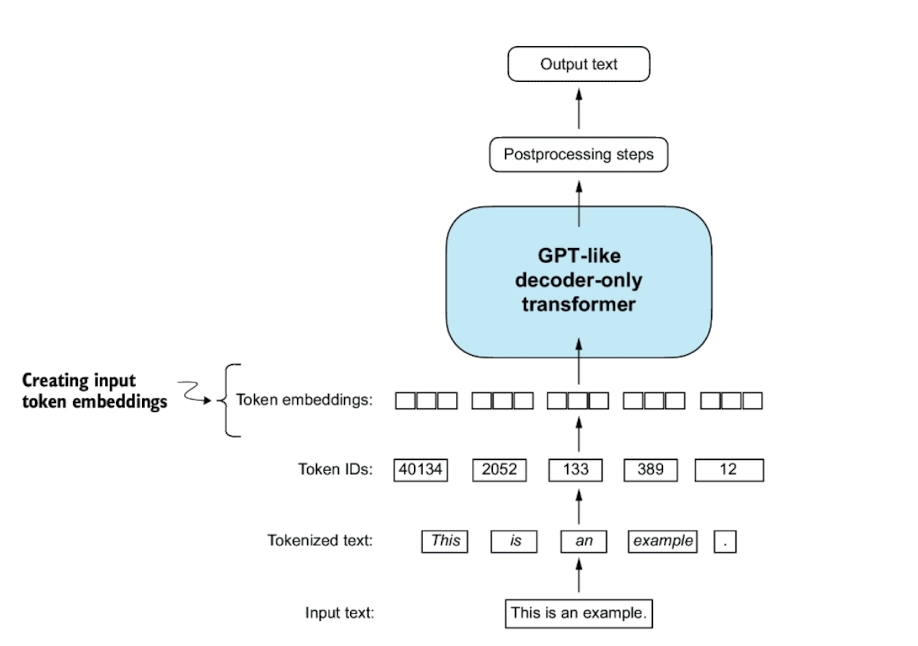

Preparation involves tokenizing text, converting text tokens to token IDs, and converting token IDs into embedding vectors. <br>
Embedding vectors carry semantic meaning. Tis is the most important aspect of vector embedding.


Embedding Matrix:

   Vocab size   X   number of dimensions of embedding

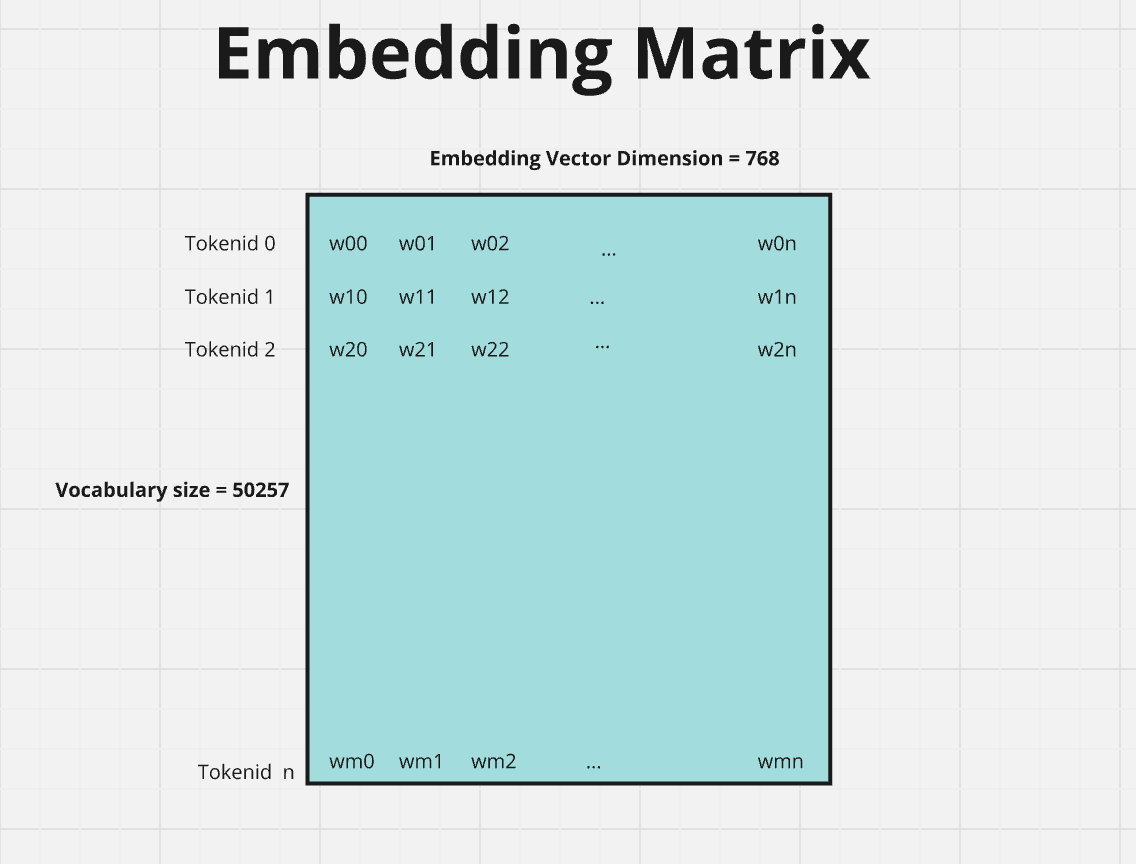

These weights are finalized as a part of the LLM training process
</div>

In [13]:
import torch
import importlib
import tiktoken
from torch.utils.data import Dataset, DataLoader


class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

In [14]:
def create_dataloader_v1(txt, batch_size=4, max_length=256, 
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):

    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader

In [15]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

In [16]:
import torch
print("PyTorch version:", torch.__version__)
dataloader = create_dataloader_v1(
    raw_text, batch_size=1, max_length=4, stride=1, shuffle=False
)

data_iter = iter(dataloader)
first_batch = next(data_iter)
print(first_batch)

PyTorch version: 2.4.1
[tensor([[10970, 33310,    35, 18379]]), tensor([[33310,    35, 18379,   198]])]


### CREATING TOKEN EMBEDDINGS

<div class="alert alert-block alert-success">
    
Let's illustrate how the token ID to embedding vector conversion works with a hands-on
example. Suppose we have the following four input tokens with IDs 2, 3, 5, and 1:</div>

In [17]:
input_ids = torch.tensor([2, 3, 5, 1])

<div class="alert alert-block alert-success">
    
For the sake of simplicity and illustration purposes, suppose we have a small vocabulary of
only 6 words (instead of the 50,257 words in the BPE tokenizer vocabulary), and we want
to create embeddings of size 3 (in GPT-3, the embedding size is 12,288 dimensions):

</div>

<div class="alert alert-block alert-success">
    
Using the vocab_size and output_dim, we can instantiate an embedding layer in PyTorch,
setting the random seed to 123 for reproducibility purposes:

Note that the weights are randomly initialized and it will chage during training as a part of back propogation

</div>

In [19]:
vocab_size = 6
output_dim = 3

torch.manual_seed(123)
embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

<div class="alert alert-block alert-info">
    
The print statement in the code prints the embedding layer's underlying
weight matrix:
    
</div>

In [20]:
print(embedding_layer.weight)
print(embedding_layer.weight[0][:])

Parameter containing:
tensor([[ 0.3374, -0.1778, -0.1690],
        [ 0.9178,  1.5810,  1.3010],
        [ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096]], requires_grad=True)
tensor([ 0.3374, -0.1778, -0.1690], grad_fn=<SliceBackward0>)


<div class="alert alert-block alert-info">
    
We can see that the weight matrix of the embedding layer contains small, random values.
These values are optimized during LLM training as part of the LLM optimization itself, as we
will see in upcoming chapters. Moreover, we can see that the weight matrix has six rows
and three columns. There is one row for each of the six possible tokens in the vocabulary.
And there is one column for each of the three embedding dimensions.
    
</div>

<div class="alert alert-block alert-success">
    
After we instantiated the embedding layer, let's now apply it to a token ID to obtain the
embedding vector:

</div>

In [21]:
print(embedding_layer(torch.tensor([3])))

tensor([[-0.4015,  0.9666, -1.1481]], grad_fn=<EmbeddingBackward0>)


<div class="alert alert-block alert-info">
    
If we compare the embedding vector for token ID 3 to the previous embedding matrix, we
see that it is identical to the 4th row (Python starts with a zero index, so it's the row
corresponding to index 3). In other words, the embedding layer is essentially a look-up
operation that retrieves rows from the embedding layer's weight matrix via a token ID.

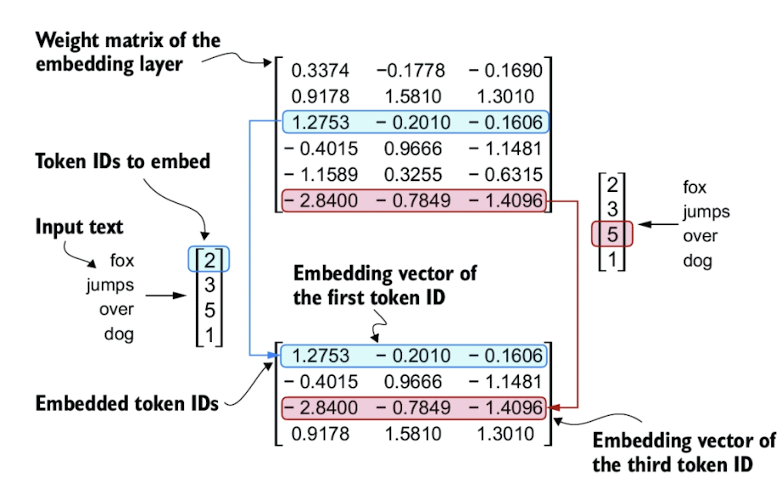

Embedding layers perform a lookup operation, retrieving the embedding vector corresponding to the token ID from the embedding layer’s weight matrix. For instance, the embedding vector of the token ID 5 is the sixth row of the embedding layer weight matrix (it is the sixth instead of the fifth row because Python starts counting at 0).
    
</div>

<div class="alert alert-block alert-success">
    
Previously, we have seen how to convert a single token ID into a three-dimensional
embedding vector. Let's now apply that to all four input IDs we defined earlier
(torch.tensor([2, 3, 5, 1])):

</div>

In [23]:
print(embedding_layer(input_ids))

tensor([[ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-2.8400, -0.7849, -1.4096],
        [ 0.9178,  1.5810,  1.3010]], grad_fn=<EmbeddingBackward0>)


**POSITIONAL EMBEDDINGS (ENCODING WORD POSITIONS)**

In [16]:
vocab_size = 50257
output_dim = 256

token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

In [17]:
max_length = 4
dataloader = create_dataloader_v1(
    raw_text, batch_size=8, max_length=max_length,
    stride=max_length, shuffle=False
)
data_iter = iter(dataloader)
inputs, targets = next(data_iter)

In [19]:
print("Token IDs:\n", inputs)
print("\nInputs shape:\n", inputs.shape)

Token IDs:
 tensor([[10970, 33310,    35, 18379],
        [  198, 15749, 40417,   198],
        [  198,    40,   550,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  198,   198, 11274,  5891],
        [ 1576,   438,   568,   340]])

Inputs shape:
 torch.Size([8, 4])


In [20]:
token_embeddings = token_embedding_layer(inputs)
print(token_embeddings.shape)

torch.Size([8, 4, 256])


In [21]:
context_length = max_length
pos_embedding_layer = torch.nn.Embedding(context_length, output_dim)

In [22]:
pos_embeddings = pos_embedding_layer(torch.arange(max_length))
print(pos_embeddings.shape)

torch.Size([4, 256])


In [23]:
input_embeddings = token_embeddings + pos_embeddings
print(input_embeddings.shape)

torch.Size([8, 4, 256])
